Sentinel-2 Imagery and Geograhic Boundaries Exploration

In [1]:
! pip install -r ../requirements.txt

In [2]:
import sys
import os
sys.path.append('C:/Users/Sania Serrao/projects/LULCmapsGen/src')
import requests
import json

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping libraries
import ee #earth engine
import eeconvert as eec
import geemap
import folium


import torch
from torchvision import datasets, models, transforms
     

In [3]:
from geodata import get_geodata
from geo_plot import plot_district, plot_sat_img,plot_tiles,plot_crop
from generate_image import generate_image
from export_image import export_image
from generate_tiles import generate_tiles





In [4]:
ee.Authenticate()


True

In [5]:
ee.Initialize(project="")

In [6]:

repo_dir="C:/Users/Sania Serrao/projects/LULCmapsGen/data"
#obtaining the geodata for india at the district level
ISO='IND'
AMD='ADM3'
file_path=get_geodata(ISO, AMD, repo_dir)



GeoJSON file saved at: C:/Users/Sania Serrao/projects/LULCmapsGen/data\geoboundaryIND_ADM3.geojson


In [7]:
geobound = gpd.read_file(file_path)
print("Data dimensions: {}".format(geobound.shape))
print("Column names:", geobound.columns)
print(geobound.info())
pd.set_option('max_colwidth', 20)
print(geobound.head(5))


Data dimensions: (6824, 6)
Column names: Index(['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType',
       'geometry'],
      dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6824 entries, 0 to 6823
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   shapeName   6824 non-null   object  
 1   shapeISO    6824 non-null   object  
 2   shapeID     6824 non-null   object  
 3   shapeGroup  6824 non-null   object  
 4   shapeType   6824 non-null   object  
 5   geometry    6824 non-null   geometry
dtypes: geometry(1), object(5)
memory usage: 320.0+ KB
None
         shapeName shapeISO              shapeID shapeGroup shapeType  \
0   Ghograpar (Pt)           7132399B28259355...        IND      ADM3   
1        Chapar Pt           7132399B69733852...        IND      ADM3   
2    Barnagar (Pt)           7132399B97438747...        IND      ADM3   
3    Bilasipara Pt           7132399B22541426

In [8]:
print(geobound['shapeName'])
#geobound['shapeName'].to_csv('district_list.csv', index=False) 

0        Ghograpar (Pt)
1             Chapar Pt
2         Barnagar (Pt)
3         Bilasipara Pt
4       Bongaigaon (Pt)
             ...       
6819              Sagar
6820               Lava
6821             Pedong
6822            Kalyani
6823            Kolkata
Name: shapeName, Length: 6824, dtype: object


In [9]:
print(geobound[geobound['shapeName'] =='Delhi Cantonment']) 

             shapeName shapeISO              shapeID shapeGroup shapeType  \
1750  Delhi Cantonment           7132399B26804271...        IND      ADM3   

                 geometry  
1750  POLYGON ((77.102...  


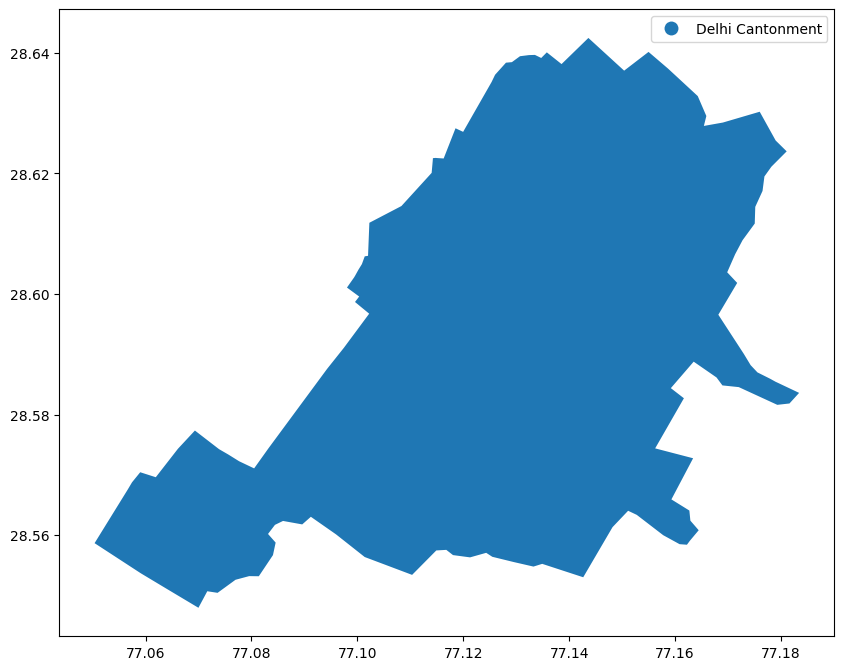

In [10]:
roi='Delhi Cantonment'
plot_district(geobound,roi)

In [11]:

region  = geobound.loc[geobound.shapeName == roi]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #converting to feature collection


# Generate RGB image 
image = generate_image(
    region,
    product='COPERNICUS/S2', # Use Sentinel 2  
    min_date='2021-01-01', 
    max_date='2023-12-31',
    cloud_pct=10
)

# Visualize map
Map = geemap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image,{},'Sentinel2')
Map.addLayerControl()


'''image generated via the aggregation of the sentinel 2 images for the year 2023 is superimposed over the map of Udupi district for visualization'''

c:\Users\Sania Serrao\AppData\Local\Programs\Python\Python310\lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


'image generated via the aggregation of the sentinel 2 images for the year 2023 is superimposed over the map of Udupi district for visualization'

In [12]:
Map

Map(center=[28.59160722713213, 77.12711550686852], controls=(WidgetControl(options=['position', 'transparent_b…

In [50]:
filename='sentinel2'+'_'+roi
path=export_image(image,filename,region.geometry())

Exporting sentinel2_Delhi Cantonment.zip...
Download URL: https://earthengine.googleapis.com/v1/projects/97158930735/thumbnails/e701cf45c06812a2582c96bdd8cb5db0-304c1bc6542f61f44d3915197aa577fb:getPixels
ZIP file successfully saved to C:/Users/Sania Serrao/projects/LULCmapsGen/images\sentinel2_Delhi Cantonment\sentinel2_Delhi Cantonment.zip
RGB image saved to C:/Users/Sania Serrao/projects/LULCmapsGen/images\sentinel2_Delhi Cantonment\sentinel2_Delhi Cantonment_RGB.tif


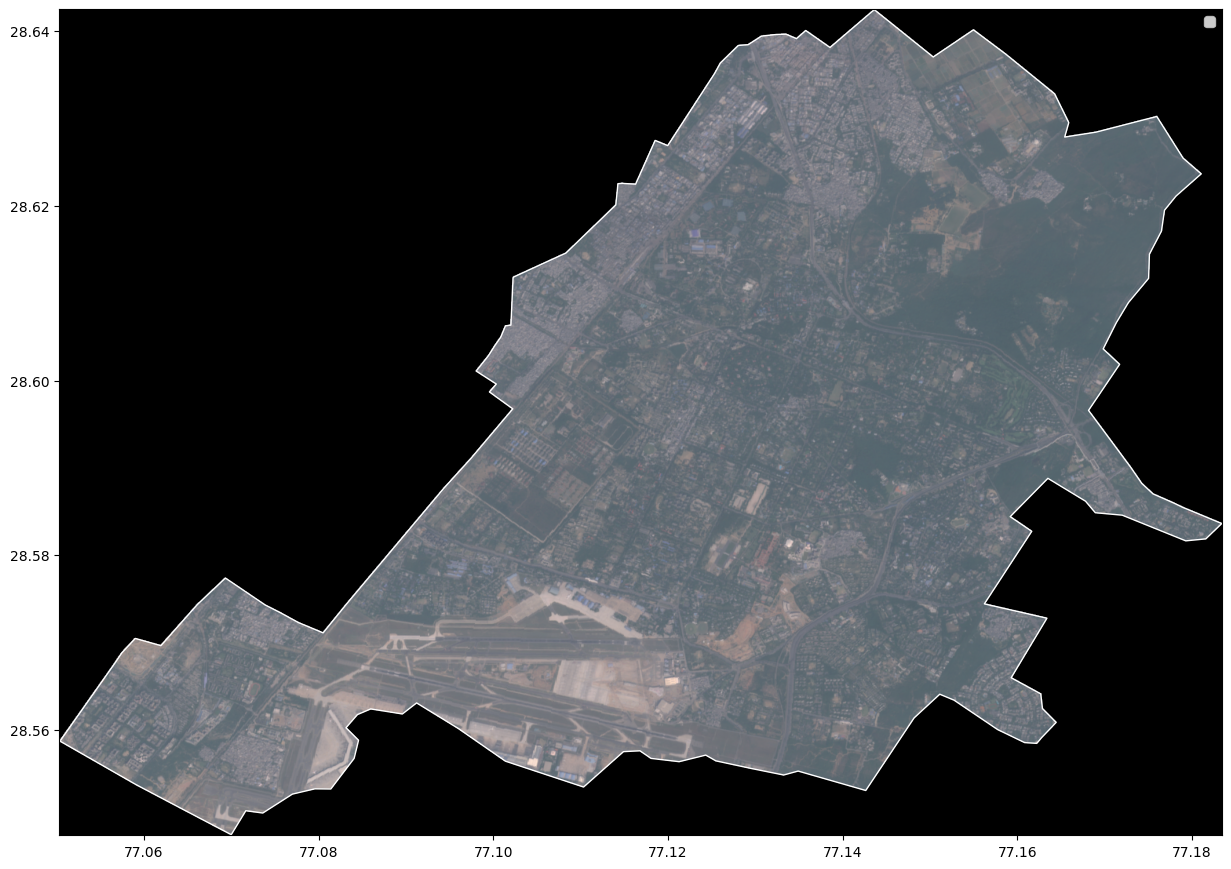

In [13]:
img_path='C:/Users/Sania Serrao/projects/LULCmapsGen/images/sentinel2_Delhi Cantonment/sentinel2_Delhi Cantonment_RGB.tif'
plot_sat_img(img_path,geobound,roi)

In [ ]:
roi='Delhi Cantonment'
img_path='C:/Users/Sania Serrao/projects/LULCmapsGen/images/sentinel2_Delhi Cantonment/sentinel2_Delhi Cantonment_RGB.tif'
geobound=gpd.read_file("C:/Users/Sania Serrao/projects/LULCmapsGen/data/geoboundaryIND_ADM3.geojson")
region=geobound.loc[geobound.shapeName == roi]




In [19]:
output_file = os.path.join('C:/Users/Sania Serrao/projects/LULCmapsGen/data', '{}.geojson'.format(roi))
tiles = generate_tiles("C:/Users/Sania Serrao/projects/LULCmapsGen/images/sentinel2_Delhi Cantonment/sentinel2_Delhi Cantonment_RGB.tif", output_file, roi, size=64)
tiles = tiles.to_crs(region.crs)
print('Data dimensions: {}'.format(tiles.shape))


Data dimensions: (408, 2)


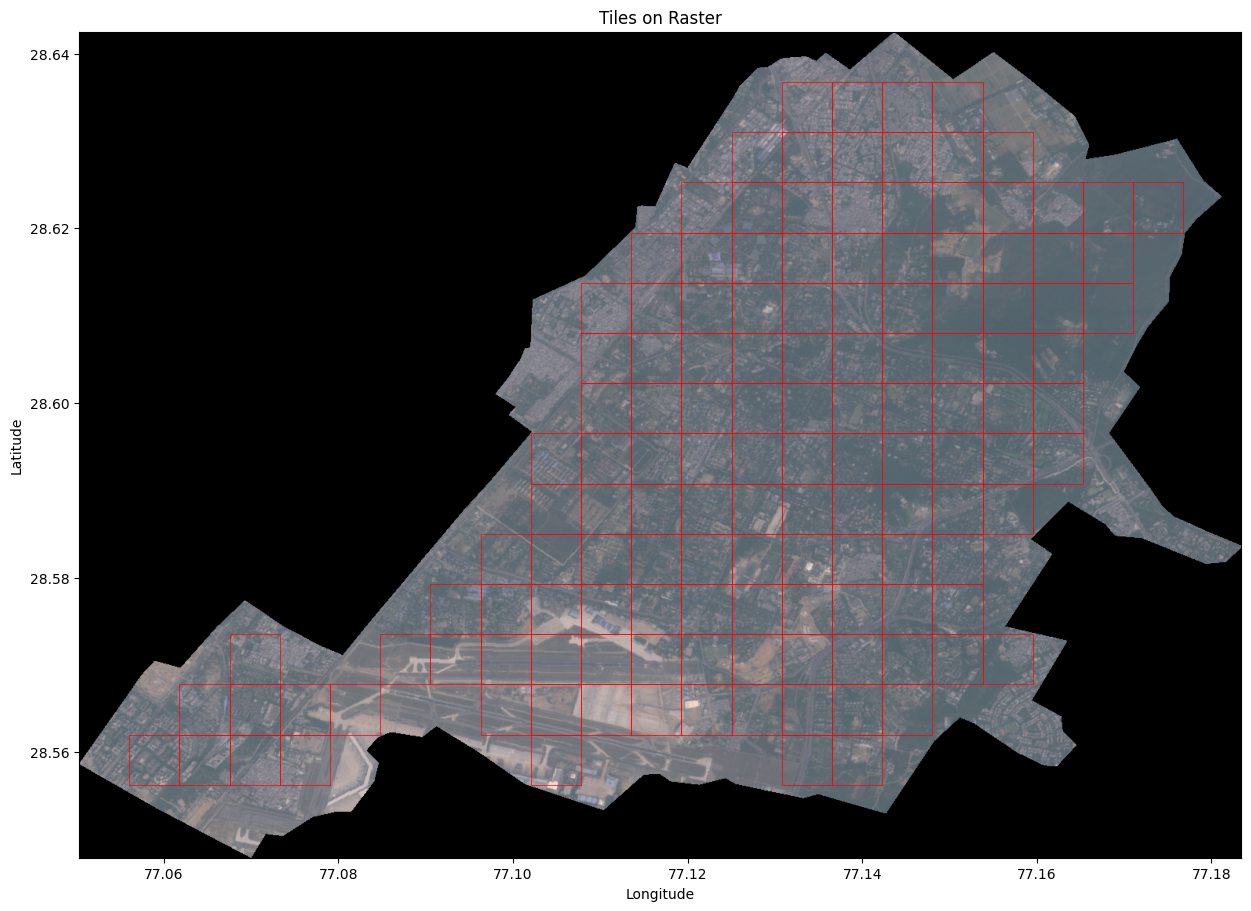

In [16]:
raster_tiles=plot_tiles(img_path, tiles, region)

In [20]:
print(raster_tiles['id'])

31     delhi cantonment_31
47     delhi cantonment_47
48     delhi cantonment_48
63     delhi cantonment_63
64     delhi cantonment_64
              ...         
331    delhi cantonment...
343    delhi cantonment...
344    delhi cantonment...
345    delhi cantonment...
360    delhi cantonment...
Name: id, Length: 137, dtype: object


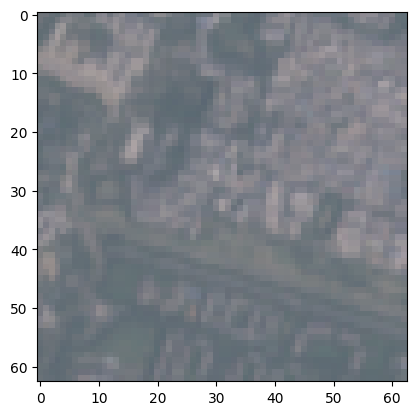

In [18]:
plot_crop(img_path, [raster_tiles.iloc[3]['geometry']]) 